# LTLF with SARIMAX 

In [1]:
#%pip install pandera
import numpy as np
import pandas as pd
import pandera as pa
from typing import Type, Optional
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta
import datetime

## Data Cleaning

The first thing that needs to happen so that we can perform a time series analysis is the conversion of dates and settlement periods into actual datetime objects. I will use the Pandas builtin `.to_datetime` for most of the parsing, but there are multiple date formats in the data, so I will have to treat each individually. I then write some functions to aid in converting settlement periods to DateTimes

In [2]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND", "EMBEDDED_SOLAR_GENERATION", "EMBEDDED_SOLAR_CAPACITY"]]

In [3]:
# Since multiple date formats appear in this csv, checking that parsing function works for both.
raw_date1 = "05-JUN-2022"
raw_date2 = "2023-06-05"

parsed_date1 = pd.to_datetime(raw_date1)
parsed_date2 = pd.to_datetime(raw_date2)

print(parsed_date1, parsed_date2)
print(type(parsed_date1), type(parsed_date2))

2022-06-05 00:00:00 2023-06-05 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [4]:
# List comprehensions are slightly faster than hidden for-loops in apply, and make sure that to_datetime doesn't fall back to dateutil.parser.parse
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [5]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [6]:
sett2date(df.SETTLEMENT_DATE[0], df.SETTLEMENT_PERIOD[0])

Timestamp('2009-01-01 00:15:00')

In [7]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [8]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [9]:
# timeseries data breakout
df["DAY_NAME"] = df["DATETIME"].dt.day_name()
df["MONTH"] = df["DATETIME"].dt.month
df["YEAR"] = df["DATETIME"].dt.year
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")
df["YMD"] = df["DATETIME"].values.astype("<M8[D]")

# sun_data proxy
df["sun_eff"] = pd.Series(df["EMBEDDED_SOLAR_GENERATION"] / df["EMBEDDED_SOLAR_CAPACITY"])

In [10]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,DAY_NAME,MONTH,YEAR,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN


## Exploratory Data Analysis: Trends

In [11]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

First I get a feel for the data by checking one (representative) week near the beginning of the data and average out the monthly fluctuation in all the years.

In [12]:
one_week = df[(df["DATETIME"] >= pd.to_datetime("2009-01-08")) & (df["DATETIME"] < pd.to_datetime("2009-01-15"))]

In [13]:
one_week.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,DAY_NAME,MONTH,YEAR,YEAR_MONTH,YMD,sun_eff
336,2009-01-08,1,38055,0,0,2009-01-08 00:15:00,Thursday,1,2009,2009-01-01,2009-01-08,NaN
337,2009-01-08,2,37957,0,0,2009-01-08 00:45:00,Thursday,1,2009,2009-01-01,2009-01-08,NaN
338,2009-01-08,3,37821,0,0,2009-01-08 01:15:00,Thursday,1,2009,2009-01-01,2009-01-08,NaN
339,2009-01-08,4,37165,0,0,2009-01-08 01:45:00,Thursday,1,2009,2009-01-01,2009-01-08,NaN
340,2009-01-08,5,36872,0,0,2009-01-08 02:15:00,Thursday,1,2009,2009-01-01,2009-01-08,NaN


C:\Users\Dimitrije\AppData\Local\Temp\ipykernel_19940\100940403.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  week_plot.set_xticklabels(week_plot.get_xticklabels(), rotation=45)


[Text(14252.0, 0, '2009-01-08'),
 Text(14253.0, 0, '2009-01-09'),
 Text(14254.0, 0, '2009-01-10'),
 Text(14255.0, 0, '2009-01-11'),
 Text(14256.0, 0, '2009-01-12'),
 Text(14257.0, 0, '2009-01-13'),
 Text(14258.0, 0, '2009-01-14'),
 Text(14259.0, 0, '2009-01-15')]

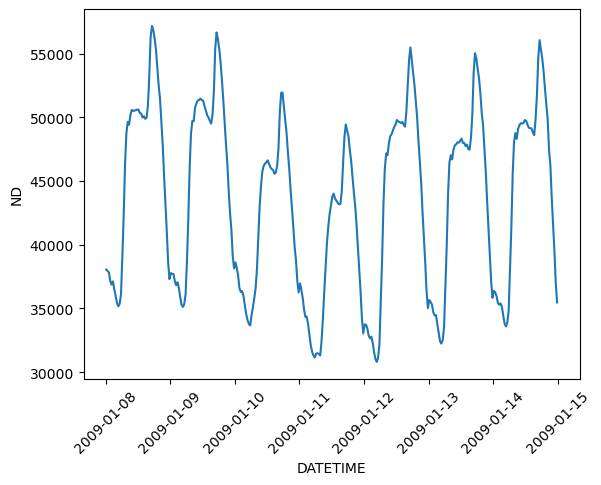

In [14]:
one_week_demand = one_week[["DATETIME","ND"]]
week_plot = sns.lineplot(data=one_week_demand, x="DATETIME", y="ND")
week_plot.set_xticklabels(week_plot.get_xticklabels(), rotation=45)

Weekends lower ND.

In [15]:
month_lvl_df = df.groupby("MONTH")["ND"].agg("mean").reset_index()

In [16]:
month_lvl_df.head()

,MONTH,ND
0,1,36803.464508
1,2,35882.142330
2,3,33704.937584
3,4,30042.515885
4,5,28337.429896


C:\Users\Dimitrije\AppData\Local\Temp\ipykernel_19940\604420649.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  year_plot.set_xticklabels(year_plot.get_xticklabels())


[Text(0.0, 0, '0'),
 Text(2.0, 0, '2'),
 Text(4.0, 0, '4'),
 Text(6.0, 0, '6'),
 Text(8.0, 0, '8'),
 Text(10.0, 0, '10'),
 Text(12.0, 0, '12'),
 Text(14.0, 0, '14')]

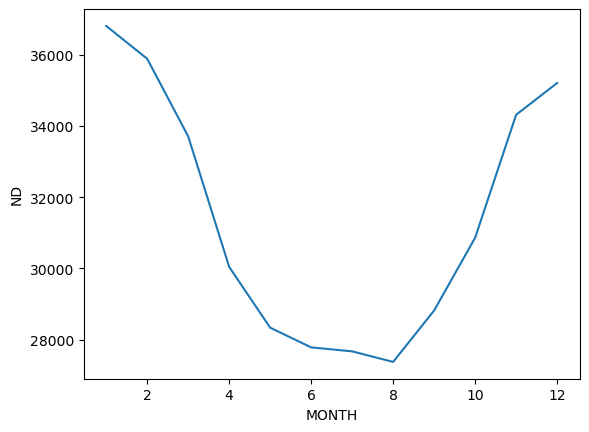

In [17]:
year_plot = sns.lineplot(x=month_lvl_df["MONTH"],y=month_lvl_df["ND"], data=month_lvl_df)
year_plot.set_xticklabels(year_plot.get_xticklabels())

Summer months -> lower ND

In [18]:
post_2009 = df.where(df["YEAR_MONTH"] > pd.to_datetime("2009-01-01"))
ym_lvl_df = post_2009.groupby("YEAR_MONTH")["ND"].agg("mean").reset_index()

C:\Users\Dimitrije\AppData\Local\Temp\ipykernel_19940\3455183066.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ym_plot.set_xticklabels(ym_plot.get_xticklabels(), rotation=45)


[Text(13879.0, 0, '2008'),
 Text(14610.0, 0, '2010'),
 Text(15340.0, 0, '2012'),
 Text(16071.0, 0, '2014'),
 Text(16801.0, 0, '2016'),
 Text(17532.0, 0, '2018'),
 Text(18262.0, 0, '2020'),
 Text(18993.0, 0, '2022'),
 Text(19723.0, 0, '2024'),
 Text(20454.0, 0, '2026')]

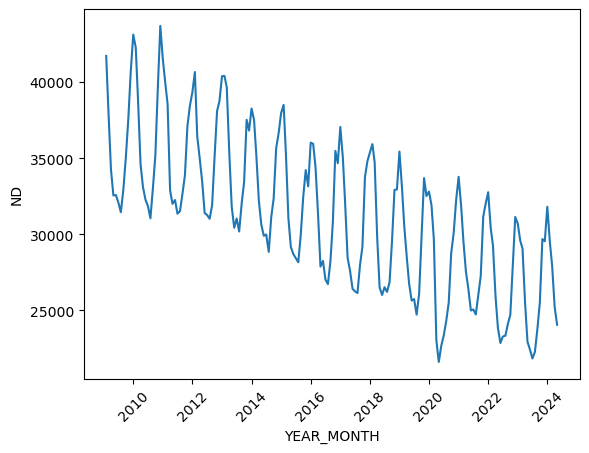

In [19]:
ym_plot = sns.lineplot(x=ym_lvl_df["YEAR_MONTH"],y=ym_lvl_df["ND"], data=ym_lvl_df)
ym_plot.set_xticklabels(ym_plot.get_xticklabels(), rotation=45)

Downwards trend.

## Regression: SARIMA (TS only)
### Train and Test Data; Functions

First, I split the data into a training and test set. Then I write some functions to be used in the TS analysis. Finally, I get the SARIMAX results.

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResultsWrapper
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [21]:
# sm complained that ND was not numeric

df["ND"] = pd.to_numeric(df["ND"], errors="coerce")

In [22]:
full_data = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

train_data = full_data[(full_data.index >= pd.to_datetime("2011-01-01")) & (full_data.index < pd.to_datetime("2022-01-01"))]

test_data = full_data[full_data.index >= pd.to_datetime("2022-01-01")]

In [23]:
def s_decomp_plot(data: Series, period: int) -> None:
    """
    Plots the seasonal decomposition of a timeseries based on the given period
    """
    decomp = sm.tsa.seasonal_decompose(data, period=period)

    trend = decomp.trend
    seasonal = decomp.seasonal
    resid = decomp.resid

    plt.figure(figsize=(15, 8))

    plt.subplot(411)
    sns.lineplot(data=data, color="blue")
    plt.xlabel("")
    plt.ylabel("National Demand (MW)")
    plt.legend().remove()

    plt.subplot(412)
    sns.lineplot(data=trend, color="orange")
    plt.xlabel("")
    plt.ylabel("Trend")

    plt.subplot(413)
    sns.lineplot(data=seasonal, color="green")
    plt.xlabel("")
    plt.ylabel("Seasonality")

    plt.subplot(414)
    sns.lineplot(data=resid, color="red")
    plt.xlabel("Year")
    plt.ylabel("Residual")

    plt.tight_layout()
    plt.show()

In [24]:
def selection_stationarity_diff(data: Series, lag_val: int) -> None:
    """
    Plots the ACF and PACF for the timeseries, as well as the differenced timeseries. Checks for stationarity of both explicitly (ADF)
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sm.graphics.tsa.plot_acf(data, lags=lag_val, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data, lags=lag_val, ax=ax[1])
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sm.graphics.tsa.plot_acf(data.diff(), lags=lag_val, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data.diff(), lags=lag_val, ax=ax[1])
    plt.show()

    adf_test = adfuller(data)
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")

    adf_test_diff = adfuller(data.diff().dropna())
    print(f"ADF Statistic (post diff): {adf_test_diff[0]}")
    print(f"p-value (post diff): {adf_test_diff[1]}")

In [25]:
def rmse_mape(fitted: Type[SARIMAXResultsWrapper], test_set: Series, exog: Optional = None) -> None:
    predictions = fitted.get_forecast(steps=len(test_set), exog=exog)
    predicted_mean = predictions.predicted_mean

    rmse = RMSE(test_set, predicted_mean)
    mape = MAPE(test_set, predicted_mean)
    
    print(f"Root Mean Squared Error: {rmse}\nMean Average Percentage Error: {mape*100:.3f}%")

In [26]:
def grid_search_sarima(data: Series, exog: Optional = None, p_list: list = [0,1,2], d_list: list = [1], q_list: list = [1,2], s_period: list = [12]) -> None:
    """
    Performs a grid search based on AIC to select best parameters for SARIMA(X) model
    """
    p = P = p_list
    q = Q = q_list
    d = D = d_list
    s = s_period

    pdq = list(itertools.product(p, d, q))
    s_pdq = list(itertools.product(P, D, Q, s))

    best_aic = float("inf")
    best_pdq = None
    best_s_pdq = None

    candidate_model_sarima = None
    candidate_fit_sarima = None

    for order in pdq:
        for s_order in s_pdq:
            try:
                candidate_model_sarima = SARIMAX(data, exog=exog, order=order, seasonal_order=s_order)
                candidate_fit_sarima = candidate_model_sarima.fit(disp=False, maxiter=1000, method='powell')
                
                if candidate_fit_sarima.aic < best_aic:
                    best_aic = candidate_fit_sarima.aic
                    best_pdq = order
                    best_s_pdq = s_order
            
            except:
                continue

    print(f"Best pdq: {best_pdq}\nBest PDQ: {best_s_pdq}\nAIC: {best_aic}")

In [27]:
def plot_fcast_sarima(fitted: Type[SARIMAXResultsWrapper], train_set: Series, test_set: Series, exog: Optional = None) -> None:
    """
    Plots the training and test data, with forecast and confidence overlaid
    """
    fcast = fitted.get_forecast(steps=len(test_set), exog=exog)
    
    fcast_values = fcast.predicted_mean
    conf_int = fcast.conf_int()

    actualized_df = pd.concat([train_set, test_set])


    plt.figure(figsize=(15, 5))
    plt.plot(train_set, label="Training Data", color="C0")
    plt.plot(test_set, label="Test Data",color="C0")
    plt.plot(fcast_values, label="Forecast", color="orange")

    plt.fill_between(fcast_values.index, 
        conf_int.iloc[:, 0], 
        conf_int.iloc[:, 1], color="orange", alpha=0.1)

    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Values")
    
    plt.show()

### Model Selection (TS)

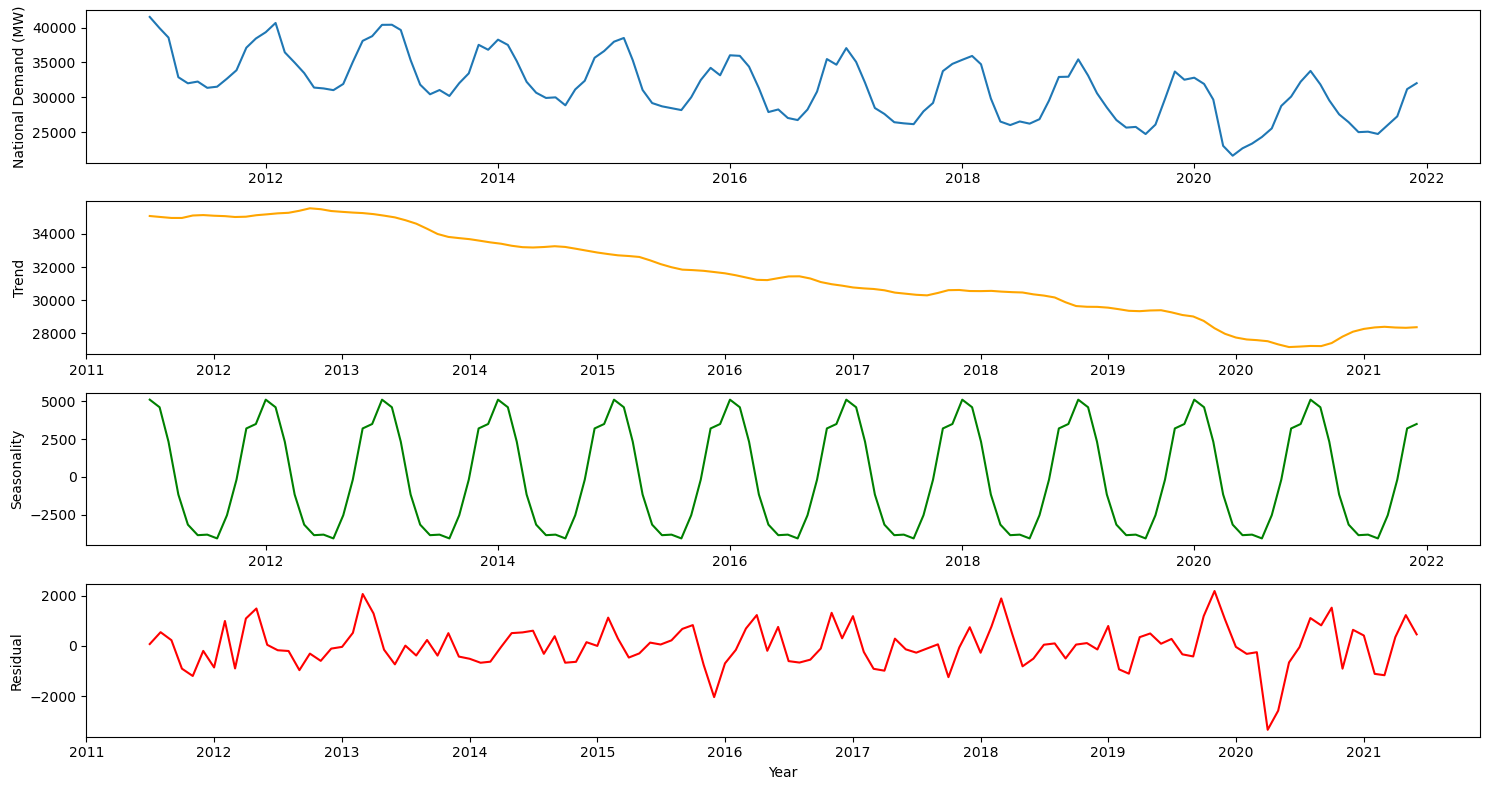

In [28]:
s_decomp_plot(train_data, 12)

I'll do one the old-fashioned way before I do a grid search.

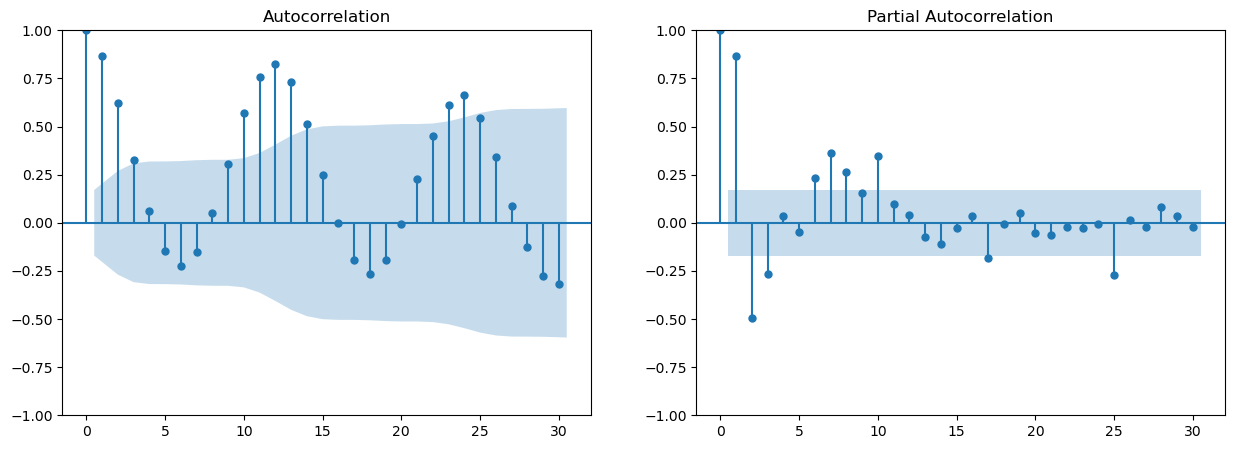

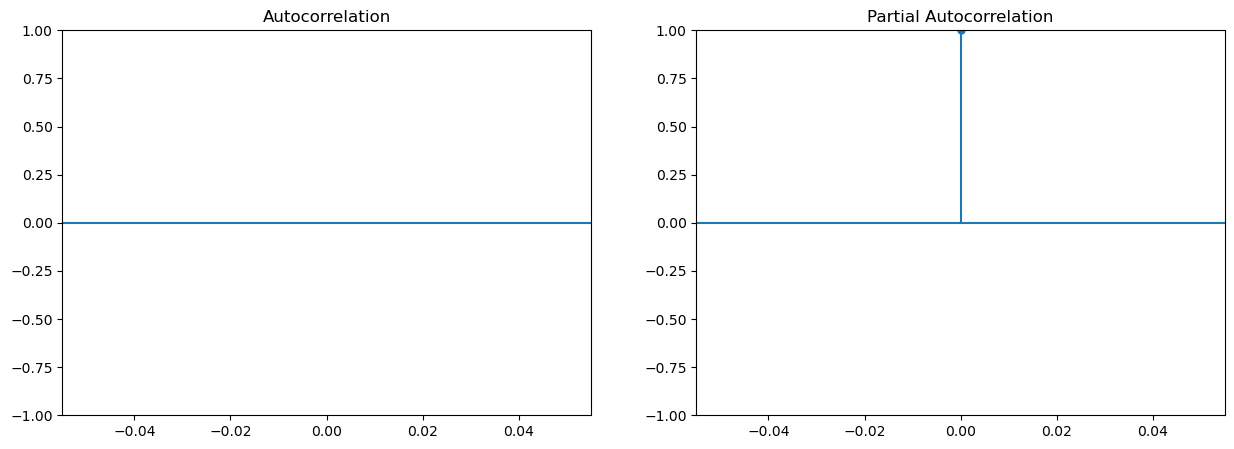

ADF Statistic: -0.6222989782285488
p-value: 0.8658633473639568
ADF Statistic (post diff): -8.570489233800481
p-value (post diff): 8.223096059429689e-14


In [29]:
selection_stationarity_diff(train_data, 30)

See the clear spikes at 2 in the ACF (MA component), and 1 in the PACF (AR component). Data is not stationary before differencing, so I(1).

In [30]:
model_sarima = SARIMAX(train_data, order=(1,1,2), seasonal_order=(1,1,2,12))
fit_sarima = model_sarima.fit(disp=False, maxiter=1000, method="powell")
print(fit_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ND   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1028.512
Date:                            Tue, 09 Jul 2024   AIC                           2071.025
Time:                                    10:46:16   BIC                           2090.478
Sample:                                01-01-2011   HQIC                          2078.924
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2721      0.804      0.338      0.735      -1.303       1.847
ma.L1         -0.4302      0.791   

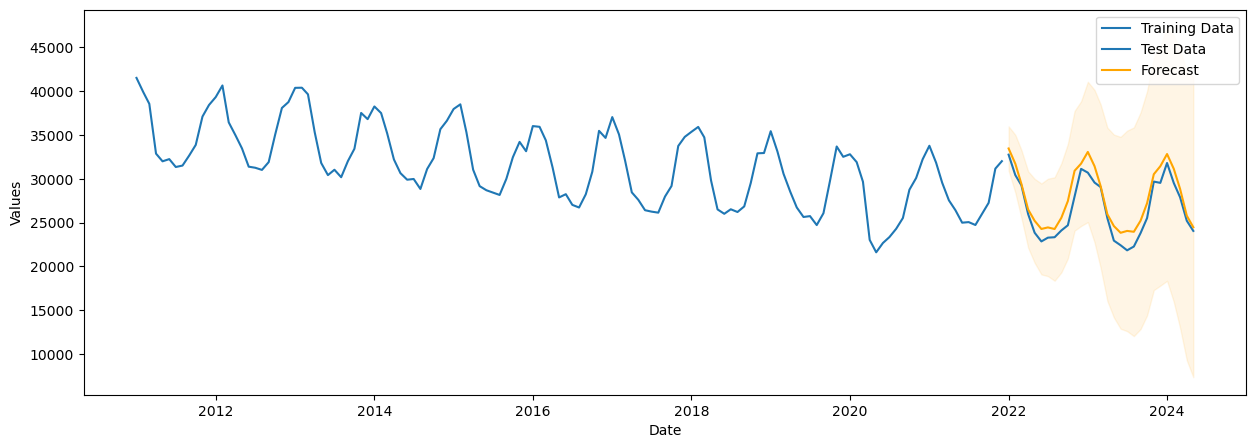

In [31]:
plot_fcast_sarima(fit_sarima, train_data, test_data)

In [32]:
rmse_mape(fit_sarima, test_data)

Root Mean Squared Error: 1478.6302910176994
Mean Average Percentage Error: 4.998%


Not bad, but let's try the grid search.

### Final Model Results

In [33]:
grid_search_sarima(train_data)

c:\Users\Dimitrije\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Dimitrije\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Dimitrije\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Dimitrije\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Dimitrije\a

Best pdq: (0, 1, 1)
Best PDQ: (0, 1, 1, 12)
AIC: 2064.826497618382


No AR order, which is weird, and MA(1). The information criteria and MAPEs know better than I do.

In [34]:
final_model_sarima = SARIMAX(train_data, order=(0,1,1), seasonal_order=(0,1,1,12))
final_fit_sarima = final_model_sarima.fit(disp=False, maxiter=1000, method="powell")
print(final_fit_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ND   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1029.413
Date:                            Tue, 09 Jul 2024   AIC                           2064.826
Time:                                    10:46:37   BIC                           2073.164
Sample:                                01-01-2011   HQIC                          2068.212
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1602      0.071     -2.263      0.024      -0.299      -0.021
ma.S.L12      -0.3201      0.022   

c:\Users\Dimitrije\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


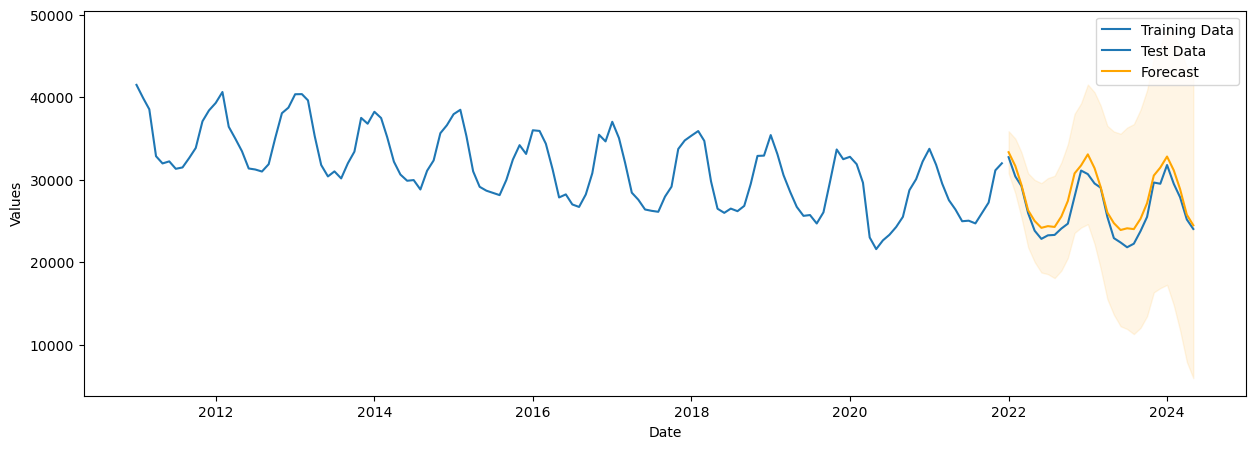

In [35]:
plot_fcast_sarima(final_fit_sarima, train_data, test_data)

In [36]:
rmse_mape(final_fit_sarima, test_data)

Root Mean Squared Error: 1482.5004407132815
Mean Average Percentage Error: 5.007%


MAPE is barely higher, but AIC is lower, so grid search preferred.

## Regression: SARIMAX (Exogenous Variables Included)

### Collection of Weather Data

In [37]:
import meteostat as met

In [38]:
df["DATETIME"][df.index[-1]]

Timestamp('2024-05-09 23:45:00')

In [39]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 6, 1)   # I want the full data from May

ldn = met.Point(51.469714, -0.463319)
edi = met.Point(55.949920, -3.359142)
cdf = met.Point(51.409223, -3.433527)

In [40]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat = met.Monthly(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat = met.Monthly(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [41]:
ldn_wdat.isna().sum()

tavg    0
wspd    0
dtype: int64

In [42]:
edi_wdat.isna().sum()

tavg    0
wspd    0
dtype: int64

In [43]:
cdf_wdat.isna().sum()

tavg    0
wspd    0
dtype: int64

Now to average the monthly weather data

In [44]:
combined_wdat = pd.concat([ldn_wdat, edi_wdat, cdf_wdat], axis=1)

mean_wdat = combined_wdat.T.groupby(combined_wdat.columns).agg("mean").T

And add the sun duration proxy

In [45]:
sun_factor_09 = df[["YEAR_MONTH", "sun_eff"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")
sun_data = sun_factor_09[(sun_factor_09.index >= pd.to_datetime("2011-01-01"))]

mean_wdat = pd.concat([mean_wdat, sun_data], axis=1)[:-1]

In [46]:
mean_wdat.iloc[-1]

tavg       13.700000
wspd       12.400000
sun_eff     0.145024
Name: 2024-05-01 00:00:00, dtype: float64

Checking stationarity for all my exog. variables, making sure that a single differencing is stationary.

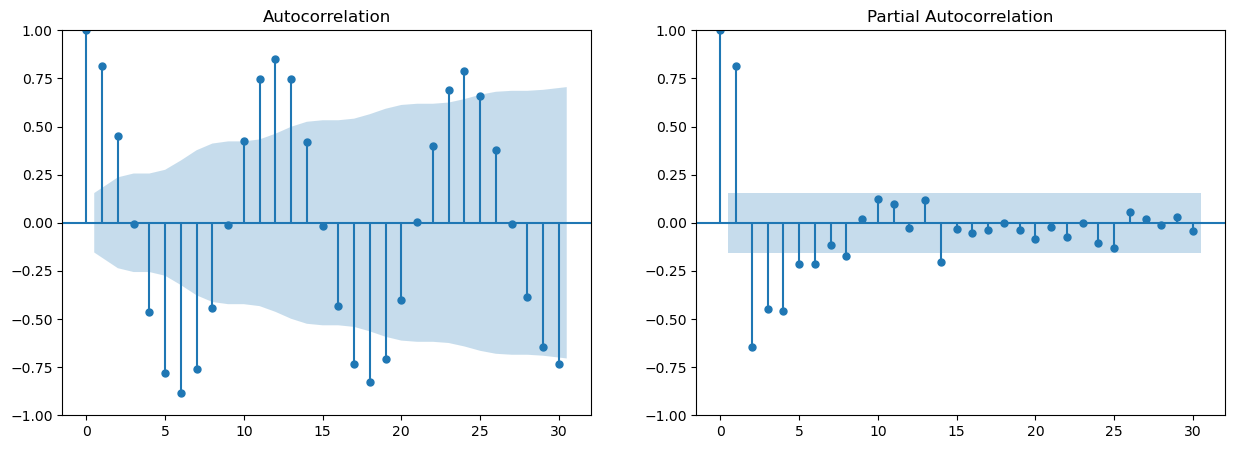

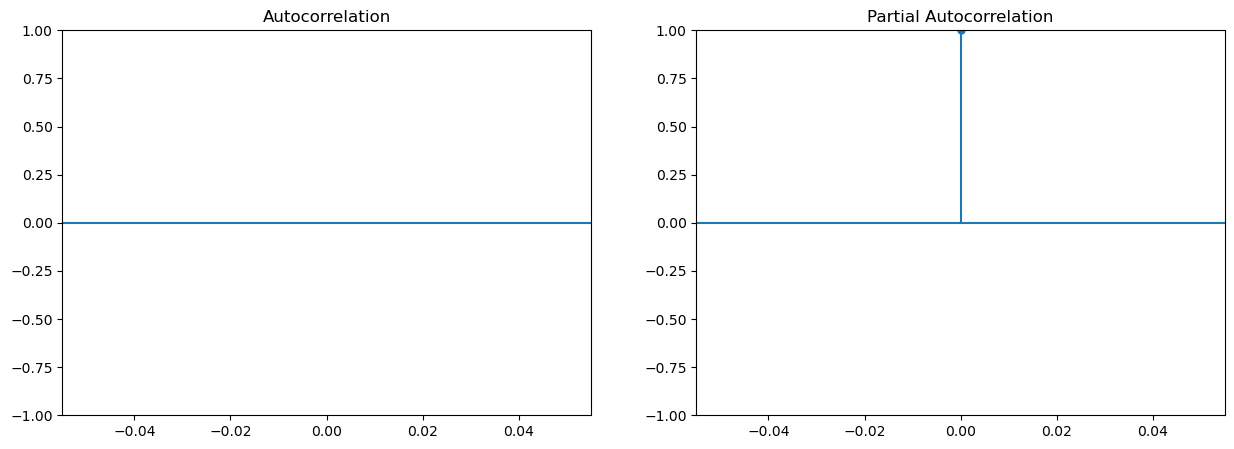

ADF Statistic: -2.9274189097280328
p-value: 0.042251197896394976
ADF Statistic (post diff): -6.642436063820535
p-value (post diff): 5.3678738490018535e-09


In [47]:
selection_stationarity_diff(mean_wdat["tavg"], 30)

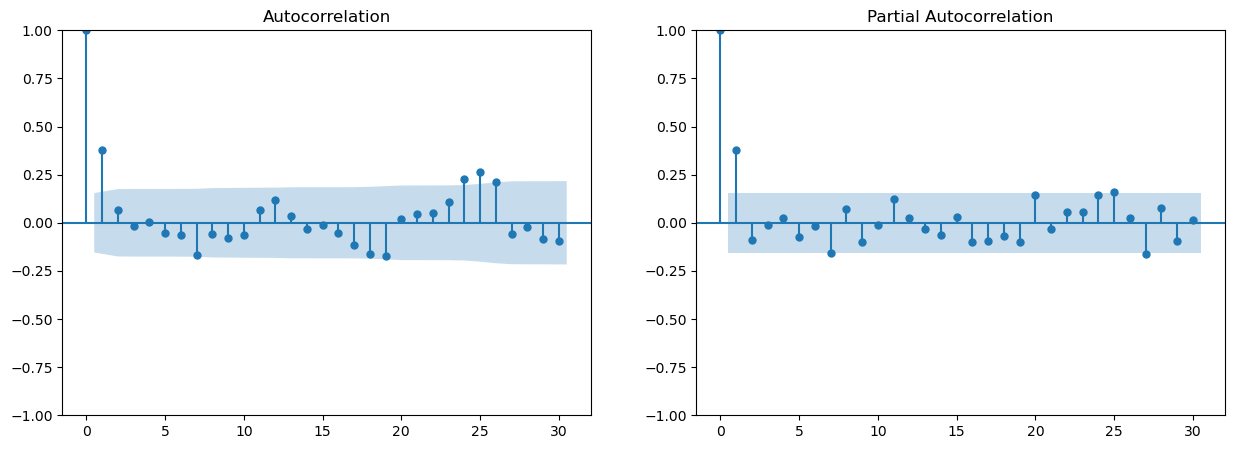

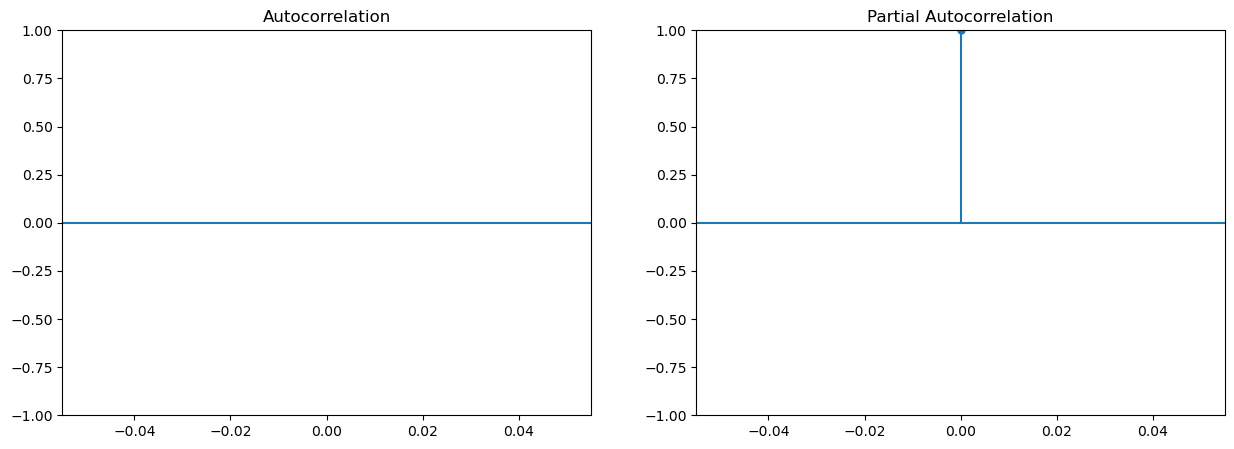

ADF Statistic: -8.337813261459896
p-value: 3.236509411104961e-13
ADF Statistic (post diff): -7.201204219017278
p-value (post diff): 2.36293598808503e-10


In [48]:
selection_stationarity_diff(mean_wdat["wspd"], 30)

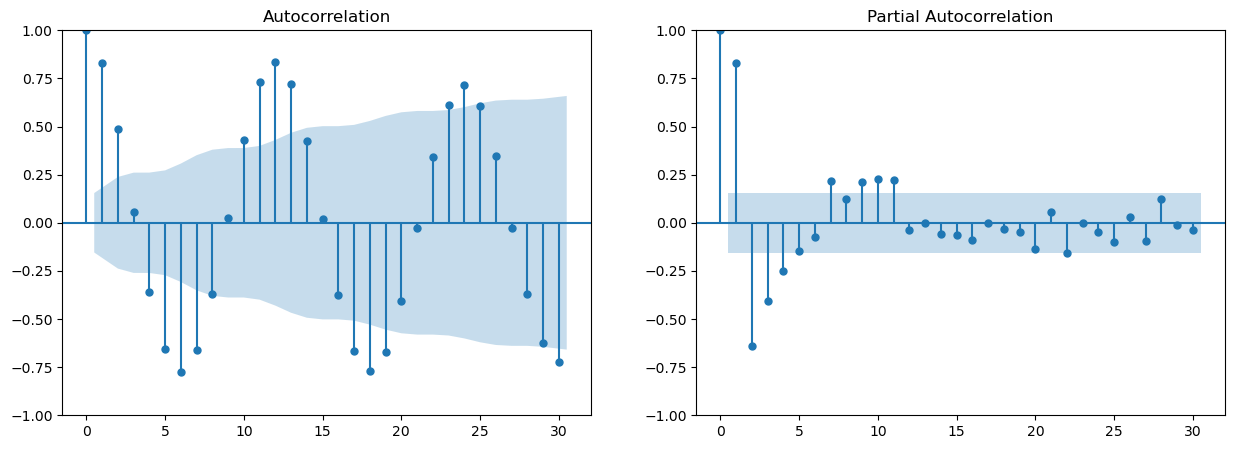

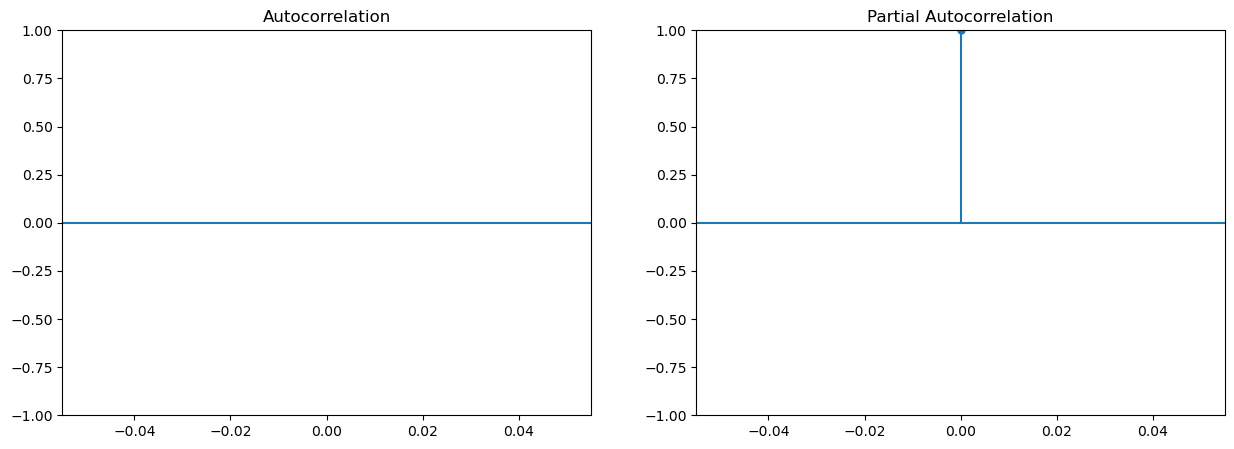

ADF Statistic: -2.9286793863452436
p-value: 0.04211317826699871
ADF Statistic (post diff): -10.86156679091665
p-value (post diff): 1.4419826132782327e-19


In [49]:
selection_stationarity_diff(mean_wdat["sun_eff"], 30)

Join the exogenous data with the time series data, and create the same train and test data.

In [50]:
agg_full = full_data[full_data.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
agg_train = agg_full[agg_full.index < pd.to_datetime("2022-01-01")]
agg_test = agg_full[(agg_full.index >= pd.to_datetime("2022-01-01")) & (agg_full.index < pd.to_datetime("2024-05-01"))]

## SARIMAX with Weather Data

Run the grid search.

In [51]:
grid_search_sarima(agg_train["ND"], exog=agg_train[["tavg", "wspd", "sun_eff"]])

Best pdq: (0, 1, 1)
Best PDQ: (0, 1, 2, 12)
AIC: 2014.2376822430717


Picks up the MA(2), still no AR, AIC good.

In [52]:
model_sarimax = SARIMAX(agg_train["ND"], exog=agg_train[["tavg", "wspd", "sun_eff"]], order=(0,1,1), seasonal_order=(0,1,2,12))
fit_sarimax = model_sarimax.fit(disp=False, maxiter=1000, method="powell")
print(fit_sarimax.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                      ND   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1000.119
Date:                                 Tue, 09 Jul 2024   AIC                           2014.238
Time:                                         10:47:11   BIC                           2033.692
Sample:                                     01-01-2011   HQIC                          2022.137
                                          - 12-01-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg        -417.2510     56.087     -7.439      0.000    -527.180    -307

sun_eff is significant!

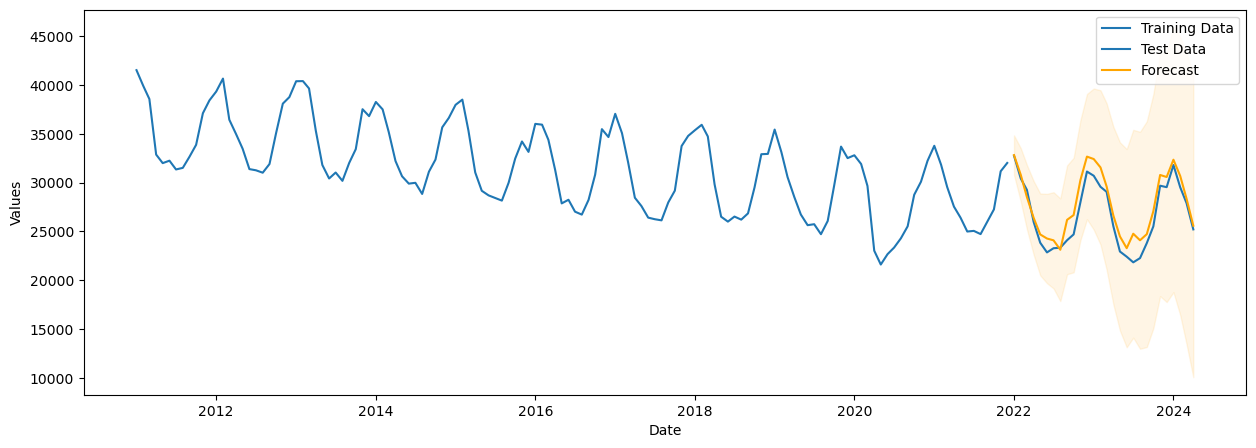

In [53]:
plot_fcast_sarima(fit_sarimax, agg_train["ND"], agg_test["ND"], agg_test[["tavg", "wspd", "sun_eff"]])

In [54]:
rmse_mape(fit_sarimax, agg_test["ND"], agg_test[["tavg", "wspd", "sun_eff"]])

Root Mean Squared Error: 1350.7185274845997
Mean Average Percentage Error: 4.503%


MAPE is down and good!

# STLF with SARIMAX

Essentially, I will do everything that I did with the previous model, but looking at daily data with a 7 day season.

In [55]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,DAY_NAME,MONTH,YEAR,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,Thursday,1,2009,2009-01-01,2009-01-01,NaN


In [76]:
full_data_dly = df[["YMD", "ND"]].groupby("YMD").agg("mean").asfreq("D")

In [77]:
w_start = datetime.datetime(2022, 1, 1)
w_end = datetime.datetime(2022, 12, 31)

In [78]:
ldn_wdat_dly = met.Daily(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat_dly = met.Daily(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat_dly = met.Daily(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [79]:
ldn_wdat_dly.isna().sum()

tavg    0
wspd    0
dtype: int64

In [80]:
edi_wdat_dly.isna().sum()

tavg    0
wspd    0
dtype: int64

In [81]:
cdf_wdat_dly.isna().sum()

tavg    0
wspd    0
dtype: int64

In [82]:
combined_wdat_dly = pd.concat([ldn_wdat_dly, edi_wdat_dly, cdf_wdat_dly], axis=1)

mean_wdat_dly = combined_wdat_dly.T.groupby(combined_wdat_dly.columns).agg("mean").T

In [83]:
mean_wdat_dly.head()

,tavg,wspd
time,,
2022-01-01,12.833333,15.133333
2022-01-02,10.100000,15.633333
2022-01-03,8.233333,19.700000
2022-01-04,3.500000,14.466667
2022-01-05,3.033333,13.666667


In [84]:
sun_factor_09_dly = df[["YMD", "sun_eff"]].groupby("YMD").agg("mean").asfreq("D")
sun_data_dly = sun_factor_09_dly[(sun_factor_09_dly.index >= pd.to_datetime("2022-01-01")) & (sun_factor_09_dly.index <= pd.to_datetime("2022-12-31"))]

mean_wdat_dly = pd.concat([mean_wdat_dly, sun_data_dly], axis=1)

In [85]:
mean_wdat_dly.head()

,tavg,wspd,sun_eff
2022-01-01,12.833333,15.133333,0.020661
2022-01-02,10.100000,15.633333,0.024186
2022-01-03,8.233333,19.700000,0.020500
2022-01-04,3.500000,14.466667,0.039364
2022-01-05,3.033333,13.666667,0.060809


In [86]:
agg_full_dly = full_data_dly[((full_data_dly.index >= pd.to_datetime("2022-01-01")) & (full_data_dly.index <= pd.to_datetime("2022-12-31")))].join(mean_wdat_dly).asfreq("D")
agg_train_dly = agg_full_dly[agg_full_dly.index < pd.to_datetime("2022-08-09")]
agg_test_dly = agg_full_dly[agg_full_dly.index >= pd.to_datetime("2022-08-09")]

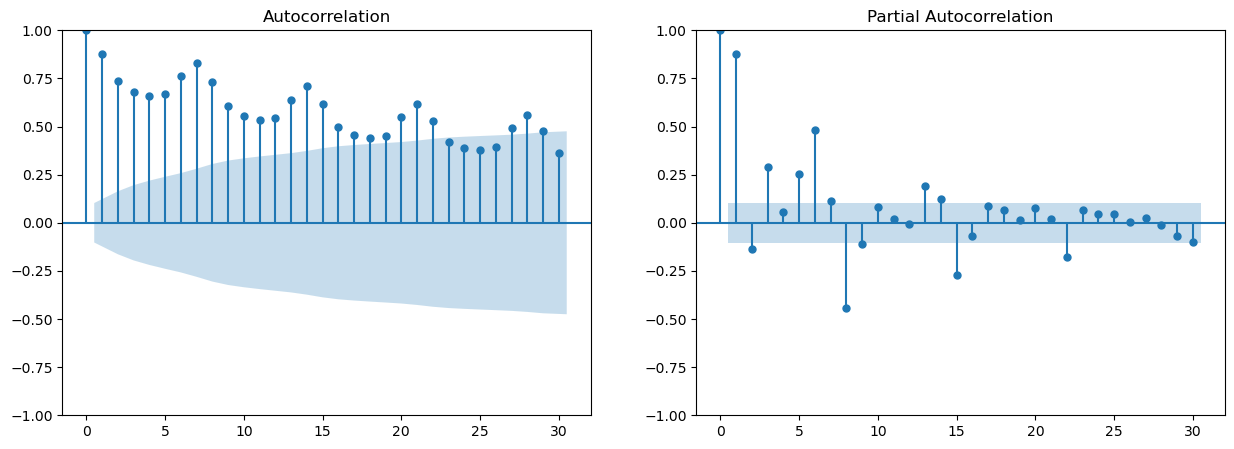

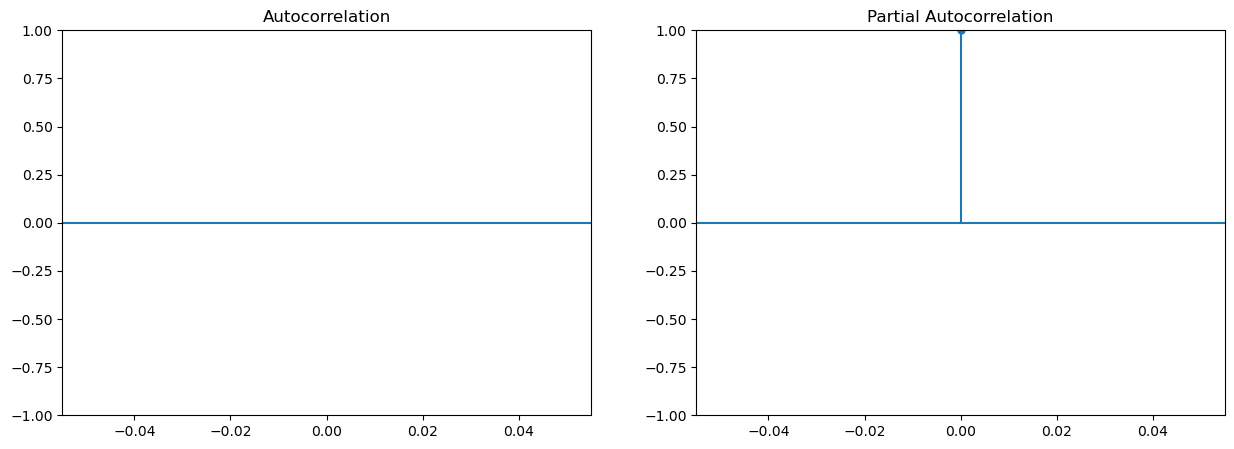

ADF Statistic: -2.2767601520749463
p-value: 0.1795728567768648
ADF Statistic (post diff): -5.371776117776565
p-value (post diff): 3.881567550472687e-06


In [67]:
selection_stationarity_diff(agg_full_dly["ND"], 30)

Try not to run the grid search below, unless you have 15 minutes to spare!

In [68]:
grid_search_sarima(agg_train_dly["ND"], exog=agg_train_dly[["tavg", "wspd", "sun_eff"]], q_list=list(range(5)), p_list=[0,1,2], s_period=[7])

Best pdq: (0, 1, 4)
Best PDQ: (0, 1, 4, 7)
AIC: 3525.612439985487


If the output of the grid search fails to render, the output is:
```
Best pdq: (0, 1, 4)
Best PDQ: (0, 1, 4, 7)
AIC: 3525.612439985487
```

Also, ignore the UserWarnings: they are just to say that the model is self-correcting its parametrisation.

In [87]:
model_sarimax_dly = SARIMAX(agg_train_dly["ND"], exog=agg_train_dly[["tavg", "wspd", "sun_eff"]], order=(0,1,4), seasonal_order=(0,1,4,12))
fit_sarimax_dly = model_sarimax_dly.fit(disp=False, maxiter=1000, method="powell")
print(fit_sarimax_dly.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ND   No. Observations:                  220
Model:             SARIMAX(0, 1, 4)x(0, 1, 4, 12)   Log Likelihood               -1869.523
Date:                            Tue, 09 Jul 2024   AIC                           3763.046
Time:                                    11:09:18   BIC                           3803.039
Sample:                                01-01-2022   HQIC                          3779.219
                                     - 08-08-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg        -102.1477     88.888     -1.149      0.250    -276.365      72.070
wspd        -151.3632     26.625   

The model is already looking worse in terms of AIC, but this is to be expected since there is a lot more data to forecast at a much higher frequency.

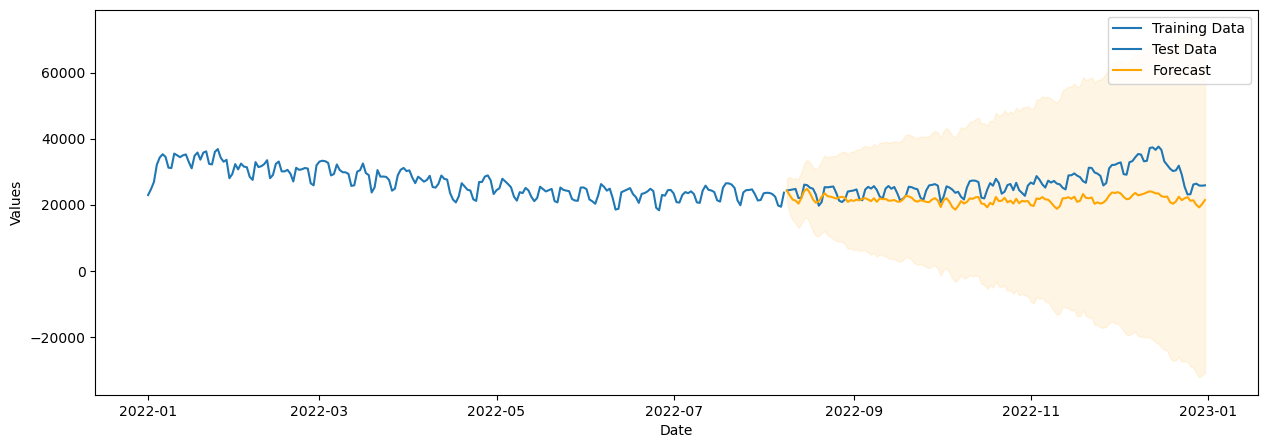

In [88]:
plot_fcast_sarima(fit_sarimax_dly, agg_train_dly["ND"], agg_test_dly["ND"], agg_test_dly[["tavg", "wspd", "sun_eff"]])

In [89]:
rmse_mape(fit_sarimax_dly, agg_test_dly["ND"], agg_test_dly[["tavg", "wspd", "sun_eff"]])

Root Mean Squared Error: 5985.556376384573
Mean Average Percentage Error: 17.500%


Again, these numbers are terrible, but that's what we hope to fix with the machine learning models.